In [48]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import galsim
import cv2 as cv
import tensorflow as tf
tf.enable_eager_execution()

%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

tf.version.VERSION

'1.15.0'

In [49]:
tf.executing_eagerly()

True

In [50]:
dat = np.load('Data/Cat-SFG-17-01-2020.npz')
dat['listgal'].shape

(300, 96, 96)

In [51]:
img1 = np.abs(fits.open('Data/psf2asec-96.psf.fits')[0].data[0,0,:,:])

### Loading PSF & SFG

In [52]:
gal = cv.resize(dat['listgal'][0,:,:], (64,64))
psf = cv.resize(galsim.Image(img1, copy=True).array, (64,64))

gal_up = cv.resize(dat['listgal'][0,:,:], (64*4,64*4))                   # Upsampled to remove alising
psf_up = cv.resize(galsim.Image(img1, copy=True).array, (64*4,64*4))

psf /= np.sum(psf)             # PSF flux = 1
psf_up /= np.sum(psf_up)

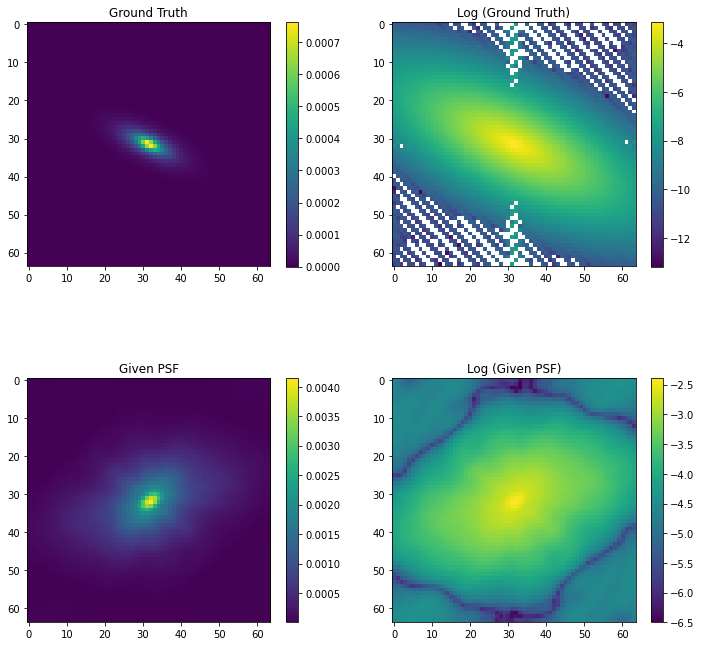

In [53]:
fig = plt.figure(figsize=(12,12))

plt.subplot(221)
plt.imshow(gal)
plt.colorbar(shrink=0.825)
plt.title('Ground Truth')

plt.subplot(222)
plt.imshow(np.log10(gal))
plt.colorbar(shrink=0.825)
plt.title('Log (Ground Truth)')

plt.subplot(223)
plt.imshow(psf)
plt.colorbar(shrink=0.825)
plt.title('Given PSF')

plt.subplot(224)
plt.imshow(np.log10(psf))
plt.colorbar(shrink=0.825)
plt.title('Log (Given PSF)')

plt.show()

### FFT(Ground Truth) + Gaussian Noise

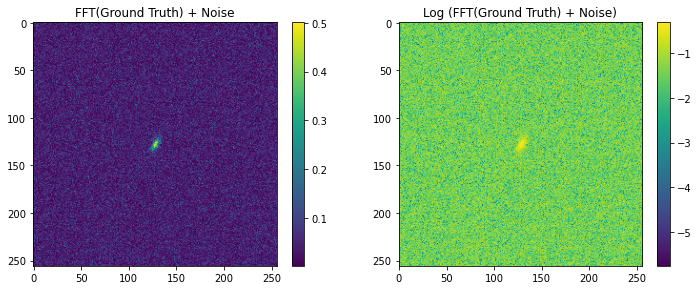

0.05687359927909601


In [54]:
gal_fft = np.fft.fftshift(np.fft.fft2(gal_up))   
psf_fft = np.fft.fftshift(np.fft.fft2(psf_up))      

# SNR(x) = l2_norm(x)/sigma_noise 

SNR = 50                                                          # Signal to noise ratio in Fourier domain
sigma_noise = np.linalg.norm(gal_fft)/SNR                         # Standard deviation of noise

gal_fft_GSO = galsim.Image(gal_fft, copy=True)                    # Stored as GSO
gal_fft_GSO.addNoise(galsim.GaussianNoise(sigma = sigma_noise)) 


fig = plt.figure(figsize=(12,12))

plt.subplot(121)
plt.imshow(np.abs(gal_fft_GSO.array))
plt.colorbar(shrink=0.375)
plt.title('FFT(Ground Truth) + Noise')

plt.subplot(122)
plt.imshow(np.log10(np.abs(gal_fft_GSO.array)))
plt.colorbar(shrink=0.375)
plt.title('Log (FFT(Ground Truth) + Noise)')

plt.show()

print(sigma_noise)

### Convolve with PSF

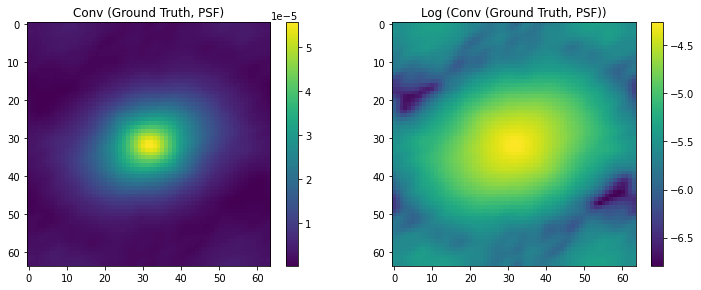

(0.030397305292520813, 0.030397305292520813)

In [55]:
conv = gal_fft_GSO.array * psf_fft

final_gal = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(conv))))     # IFFT to get back to brightness domain
final_gal = cv.resize(final_gal, (64,64))    
final_gal *= (np.sum(gal)/np.sum(final_gal))                                   # Normalisation


fig = plt.figure(figsize=(12,12))

plt.subplot(121)
plt.imshow(final_gal)
plt.colorbar(shrink=0.375)
plt.title('Conv (Ground Truth, PSF)')

plt.subplot(122)
plt.imshow(np.log10(final_gal))
plt.colorbar(shrink=0.375)
plt.title('Log (Conv (Ground Truth, PSF))')

plt.show()

np.sum(final_gal), np.sum(gal)

# ADMM in TensorFlow

In [56]:
# Convert arrays to tensors

gal_tf = tf.cast(gal, dtype='complex128')
final_gal_tf = tf.cast(final_gal, dtype='complex128')
psf_tf = tf.cast(psf, dtype='complex128')

In [163]:
# Utility Functions

def fftconvolve(image, kernel):
   
    x = tf.signal.fftshift(tf.signal.fft2d(image))
    y = tf.signal.fftshift(tf.signal.fft2d(kernel))
    result = tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(tf.signal.ifftshift(x * y))))

    return tf.cast(result, dtype='complex128')


def fft(data):

    return ( tf.convert_to_tensor(1.0/data.get_shape().as_list()[0], dtype='complex128') * 
             tf.signal.fftshift(tf.signal.fft2d(tf.signal.ifftshift(data))) )


def ifft(data):

    return ( tf.convert_to_tensor(data.get_shape().as_list()[0], dtype='complex128') *
             tf.signal.fftshift(tf.signal.ifft2d(tf.signal.ifftshift(data))) )


def soft_thresh(data, threshold):
    
    return tf.cast(tf.math.sign(tf.math.real(data)) * 
                   (tf.math.abs(data) - threshold) * 
                   tf.cast(tf.math.abs(data) >= threshold, dtype='float64'), dtype='complex128')


def nmse(signal_1, signal_2):

    return tf.keras.backend.get_value(tf.norm(signal_2 - signal_1)**2 / tf.norm(signal_1)**2)


def gen_kernel(size):
    
    shape = final_gal.shape
    dirac = np.zeros(shape)
    dirac[shape[0]//2, shape[1]//2] = 1
    gauss_kernel = cv.GaussianBlur(dirac, (size, size), 0)
    return gauss_kernel


def max_sv(psf, sigma, rho):
    
    H = tf.signal.fftshift(tf.signal.fft2d(psf))
    H_rot = tf.reverse(tf.reverse(H, axis=[0]), axis=[1])       

    def Op1(x):
        return H_rot*H*x


    def Op2(x):
        return H_rot*H*x + (sigma**2)*rho


    def scal(a,b):
        """This function returns the scalar product of a and b.
        INPUT: a, numpy array
               b, numpy array
        OUTPUT: scalar"""
        return tf.math.reduce_sum(a*tf.math.conj(b))

    def eigenvalue(Op, v):
        """This function returns the scalar product of v and Op(v).
        INPUT: Op, function
               v, numpy array
        OUTPUT: scalar"""
        Op_v = Op(v)
        return scal(v,Op_v)

    def power_iteration(Op, output_dim,epsilon=1e-10):
        """This function returns the norm of the operator using the power iteration
        method.
        INPUT: Op, function
               output_dim, tuple (dimension of the operator 2D entry)
               epsilon, positive float (error upper bound)
        OUTPUT: scalar"""
        d = np.prod(output_dim)

        v = tf.cast(np.ones(d)/np.sqrt(d), dtype='complex128')
        v = tf.reshape(v, output_dim)

        ev = eigenvalue(Op, v)

        while True:
            Op_v = Op(v)
            v_new = Op_v / tf.norm(Op_v)

            ev_new = eigenvalue(Op, v_new)
            if tf.math.abs(ev - ev_new) < epsilon:
                break

            v = v_new
            ev = ev_new

        return ev_new
    
    return power_iteration(Op2, (64,64))


def max_sv_tf(psf, sigma, rho):
    
    H = tf.signal.fft2d(psf)
    normH = tf.math.abs(tf.reverse(tf.reverse(H, axis=[0]), axis=[1]) * H + rho*sigma**2)
    return tf.cast(tf.math.reduce_max(normH), dtype='complex128')

In [170]:
# Projection - Enforce non-negative values
def proj(xi):
    
    return tf.cast(tf.math.maximum(tf.math.real(xi), 0.0), dtype='complex128')

 
# H operator
def H(data, psf):
    
    return fftconvolve(data, psf)


# H transpose operator
def Ht(data, psf):
    
    return fftconvolve(data, tf.reverse(tf.reverse(psf, axis=[0]), axis=[1]))      # rotate by 180


# The gradient
def grad(y, x_rec, psf):

    return fft(Ht(H(ifft(x_rec), psf) - y, psf))


# The cost function
def cost_func(y, x_rec, z, mu, rho, psf, var):

    temp = z - x_rec
    shape = mu.get_shape().as_list()
    
    cost_val = ( tf.cast(0.5, dtype='complex128') * rho * tf.norm(temp)**2  -
                 tf.matmul(tf.reshape(mu, [1, shape[0]*shape[1]]), tf.reshape(temp, [shape[0]*shape[1], 1]))  +
                 (tf.cast(0.5, dtype='complex128') / var) * tf.norm(y - H(ifft(x_rec), psf))**2 )
     
    return cost_val


# gradient step size update
def get_alpha(rho, sv, sigma):

    return (tf.cast(1.0, dtype='complex128') / 
            ((sv + rho*(sigma**2)) * tf.cast(1.0 + 1.0e-5, dtype='complex128')))



def runADMM(y, x_0, psf, grad, z_0, mu_0, rho_0, rho_max, eta, gamma, disp_step, ST_lambda, n_iter):
    
    cost = []
    nmse_arr = np.zeros(n_iter)
    x_opt = tf.zeros(tf.shape(y.shape), dtype='complex128')
    count = 0
    
    # ADMM parameters
    x_k = x_0
    z_k = z_0
    mu_k = mu_0
    rho_k = rho_0                                  # Augmented lagrangian hyperparameter
    delta_k = tf.cast(0.0, dtype='complex128')      
 
    # FISTA parameters
    t_k = tf.cast(1.0, dtype='complex128')
    z_fista_old = z_0
    sigma = tf.cast(0, dtype='complex128')
    
    
    # square of spectral radius of convolution matrix
    sv = max_sv(psf, sigma, rho_k)         
    

    # The gradient descent step
    alpha = get_alpha(rho_k, sv, sigma)
        
        
    for k in range(n_iter):
        
        
        # FISTA update
        
        x_k1 = z_fista_old - alpha * (grad(y, z_fista_old, psf)  + 
                                      mu_k * sigma**2  + 
                                      rho_k * sigma**2 * (z_fista_old - z_k)) 
        
        #x_k1 = soft_thresh(x_k1, ST_lambda)
        x_k1 = proj(x_k1)
        
        t_k1 = ( (tf.cast(1.0, dtype='complex128') + 
                  tf.math.sqrt(tf.cast(4.0, dtype='complex128')*t_k**2 + tf.cast(1.0, dtype='complex128'))) 
                / tf.cast(2.0, dtype='complex128') )
        
        lambda_fista = tf.cast(1.0, dtype='complex128') + (t_k -  tf.cast(1.0, dtype='complex128')) / t_k1
        
        z_fista_new = x_k + lambda_fista * (x_k1 - x_k)
        
        z_fista_old = z_fista_new
        t_k = t_k1
        
           
    
        # Denoising
        z_k1 = x_k1 + mu_k/rho_k

        gauss_kernel = tf.cast(np.expand_dims(gen_kernel(5), axis=(-1, -2)), dtype='float64')
        z_k1_4d = tf.expand_dims(tf.expand_dims(tf.math.abs(z_k1), axis=0), axis=-1)

        conv_4d = tf.nn.conv2d(z_k1_4d, gauss_kernel, strides=[1, 1, 1, 1], padding='SAME')
        z_k1 = tf.cast(tf.squeeze(conv_4d), dtype='complex128')
        
        

        # mu update
        mu_k1 = mu_k + (x_k1 - z_k1) * rho_k
    
        
        # Cost
        cost.append(cost_func(y, x_k1, z_k1, mu_k1, rho_k, psf, var=sigma**2))
        
        
        # Rho & alpha update       

        test1 = (tf.math.abs(gamma * rho_k) < tf.math.abs(rho_max))

        delta_k1 = tf.cond(test1, lambda: (tf.cast(1.0/final_gal_tf.get_shape().as_list()[0], dtype='complex128') * 
                                           (tf.norm(x_k1 - x_k) + tf.norm(z_k1 - z_k) + tf.norm(mu_k1 - mu_k))), 
                                  lambda: delta_k)
                
        test2 = (test1 and (tf.math.abs(delta_k1) > tf.math.abs(eta * delta_k)))
        
        rho_k1 = tf.cond(test2, lambda: gamma * rho_k, lambda: rho_k)
        alpha = tf.cond(test2, lambda: get_alpha(rho_k1, sv, sigma), lambda: alpha)
        
        
        
        # Update all variables
        delta_k = tf.cond(test1, lambda: delta_k1, lambda: delta_k)
        rho_k = rho_k1
        x_k = x_k1
        mu_k = mu_k1
        z_k = z_k1
        sv = max_sv(psf, sigma, rho_k)
            
        
        # Convert back to signal domain
        final_im = tf.math.abs(ifft(x_k))

        nmse_arr[k] = nmse(gal_tf, tf.cast(final_im, dtype='complex128'))
        
        
        if (k!=0) and (nmse_arr[k]<nmse_arr[k-1]) and count==0:
            x_opt = final_im
        elif (k!=0) and (nmse_arr[k]>nmse_arr[k-1]):
            count += 1
        

        if k%disp_step==0 and k!=0:
            
            fig = plt.subplots(1,3, figsize=(25,25))
            
            plt.subplot(131)
            plt.title('Reconstruction after {} iterations'.format(k))
            ax1 = plt.gca()
            im1 = ax1.imshow(tf.keras.backend.get_value(final_im))
            divider = make_axes_locatable(ax1)
            cax1 = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(im1, cax=cax1)

            plt.subplot(132)
            plt.title('Log Scale Intensity')
            plt.imshow(np.log10(tf.keras.backend.get_value(final_im)))

            plt.subplot(133)
            plt.title('Intensity Plot (Central Slice)')
            ax3 = plt.gca()
            ax3.plot(tf.keras.backend.get_value(final_im)[y.get_shape().as_list()[0]//2,:], label='rec_im')           
            ax3.plot(tf.keras.backend.get_value(gal_tf)[y.get_shape().as_list()[0]//2,:], label='gal')  
            plt.legend()
            ax3.set_aspect(1.0/ax3.get_data_ratio())
            
            plt.show(fig)
                 
            
            #print(alpha)
            print(max_sv(psf, sigma, rho_k) - max_sv_tf(psf, sigma, rho_k))
        
    return final_im, x_opt, nmse_arr, cost

/Users/ua264756/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:145: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/ua264756/opt/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


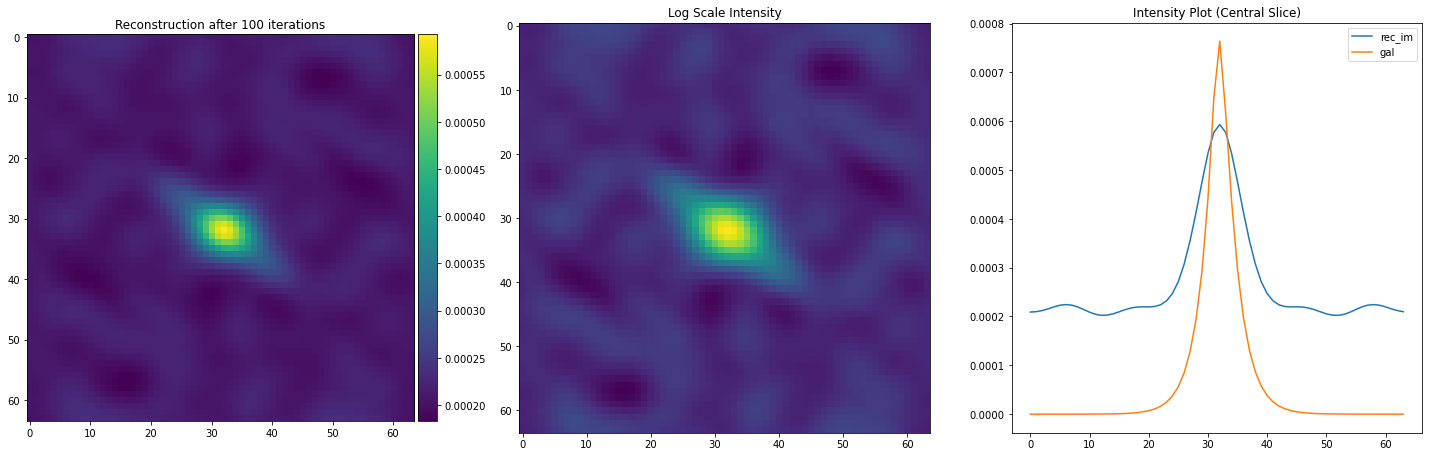

tf.Tensor((-0.0002809647103340085+0.016867253904235963j), shape=(), dtype=complex128)


/Users/ua264756/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:145: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/ua264756/opt/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


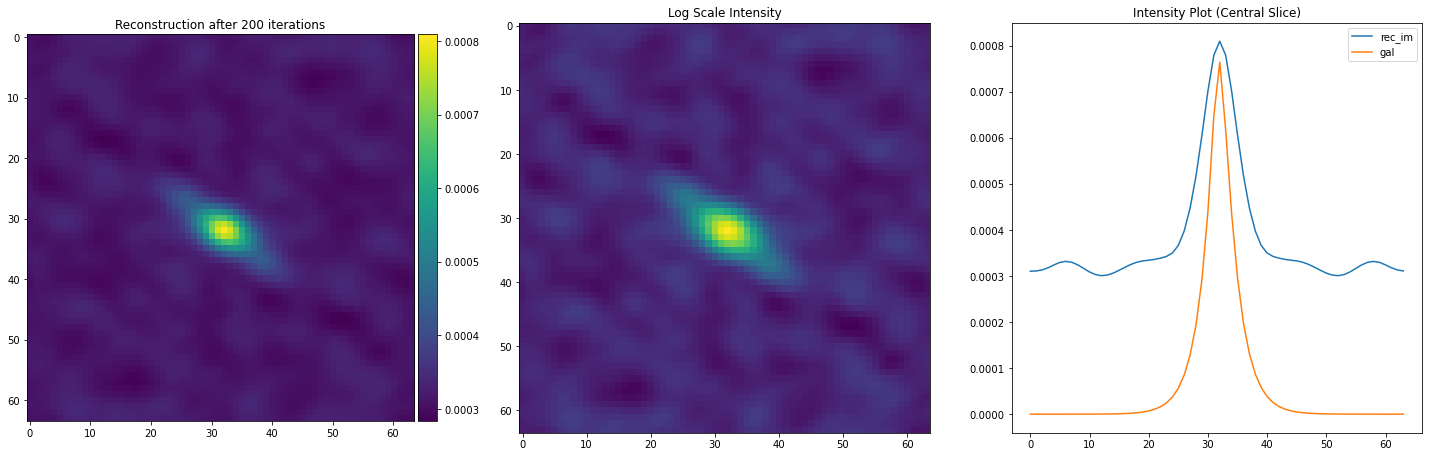

tf.Tensor((-0.0002809647103340085+0.016867253904235963j), shape=(), dtype=complex128)


/Users/ua264756/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:145: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/ua264756/opt/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


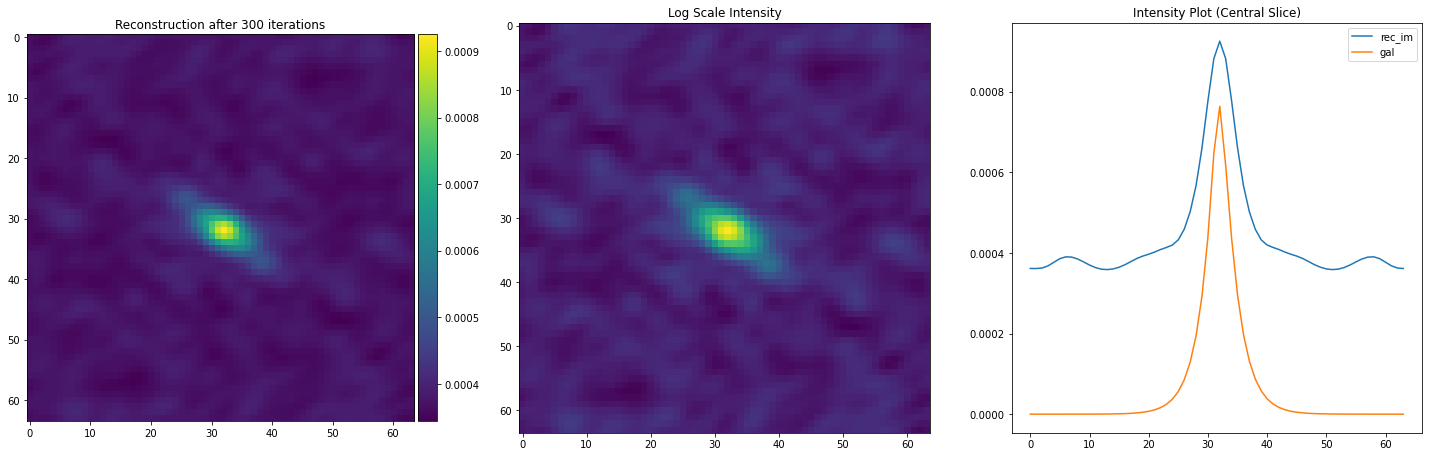

tf.Tensor((-0.0002809647103340085+0.016867253904235963j), shape=(), dtype=complex128)


/Users/ua264756/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:145: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/ua264756/opt/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


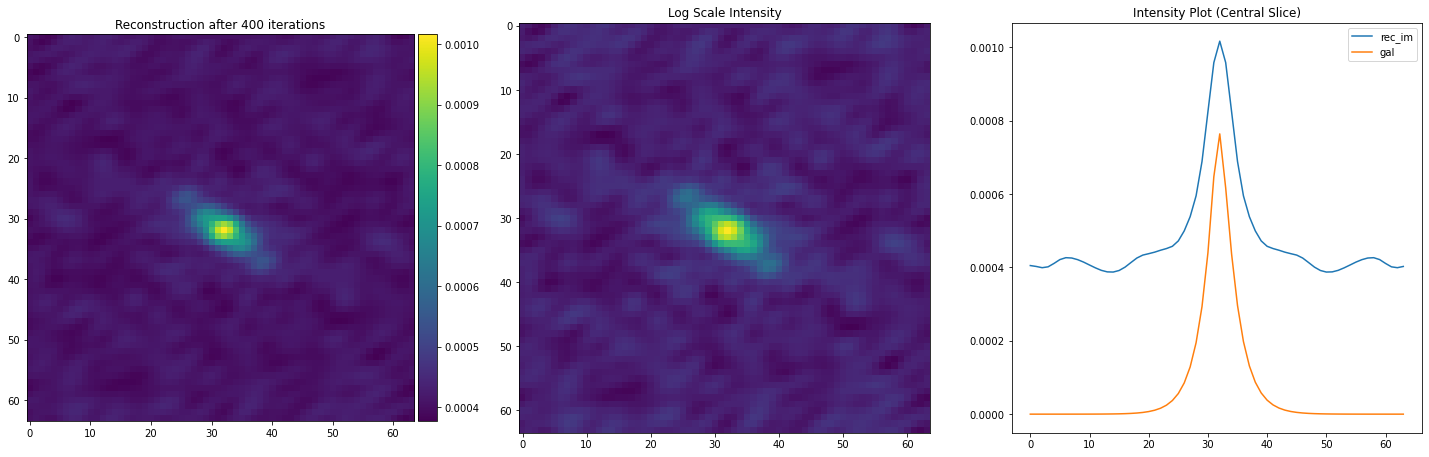

tf.Tensor((-0.0002809647103340085+0.016867253904235963j), shape=(), dtype=complex128)


/Users/ua264756/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:145: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/ua264756/opt/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


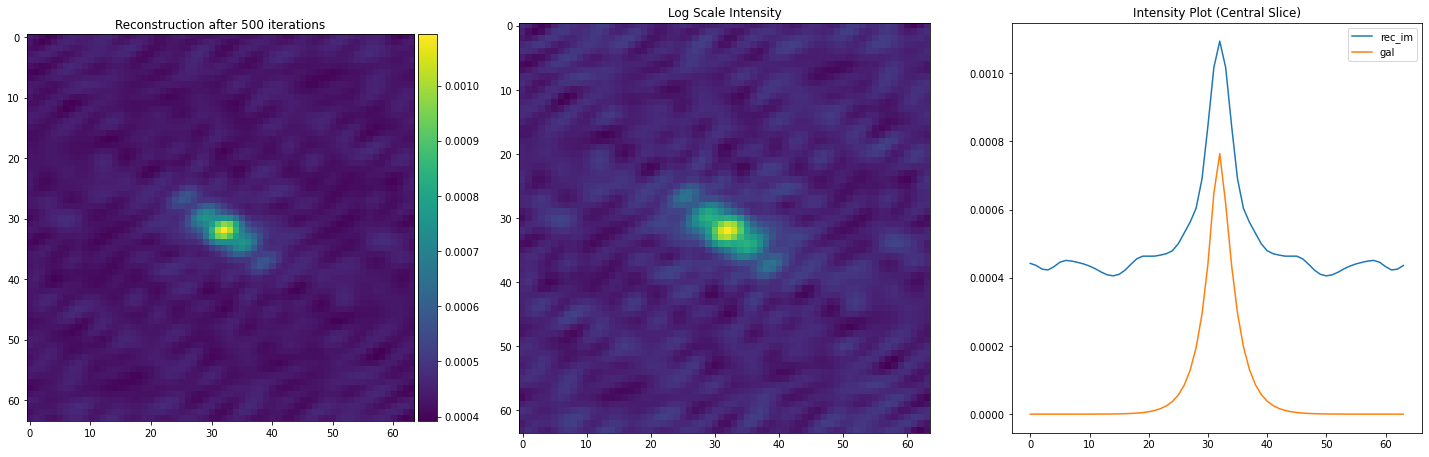

tf.Tensor((-0.0002809647103340085+0.016867253904235963j), shape=(), dtype=complex128)


/Users/ua264756/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:145: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/ua264756/opt/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


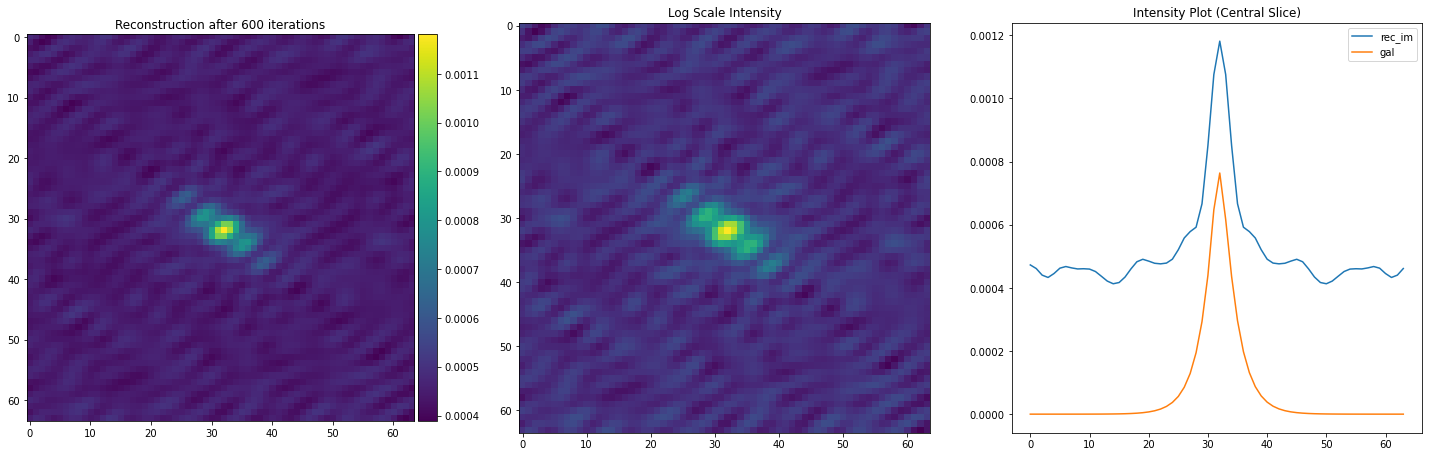

tf.Tensor((-0.0002809647103340085+0.016867253904235963j), shape=(), dtype=complex128)


In [171]:
n_iter = 601
disp_step = 100

# ADMM parameters (initial)
x_0 = tf.zeros(tf.shape(final_gal_tf), dtype='complex128')
z_0 = tf.zeros(tf.shape(final_gal_tf), dtype='complex128')
mu_0 = tf.cast(0.0, dtype='complex128')
rho_0 = tf.cast(50.0, dtype='complex128')         # Augmented lagrangian hyperparameter
rho_max = tf.cast(200.0, dtype='complex128')      # max rho value
eta = tf.cast(0.5, dtype='complex128')            # should be between - [0, 1)
gamma = tf.cast(1.4, dtype='complex128')          # multiplicative rho factor -- Should be > 1


# Deconvolve the image
final_im, x_opt, nmse_arr, cost = runADMM(final_gal_tf, x_0, psf_tf, grad, z_0, mu_0, rho_0, 
                                          rho_max, eta, gamma, disp_step, ST_lambda=1.0e-8, n_iter=n_iter)

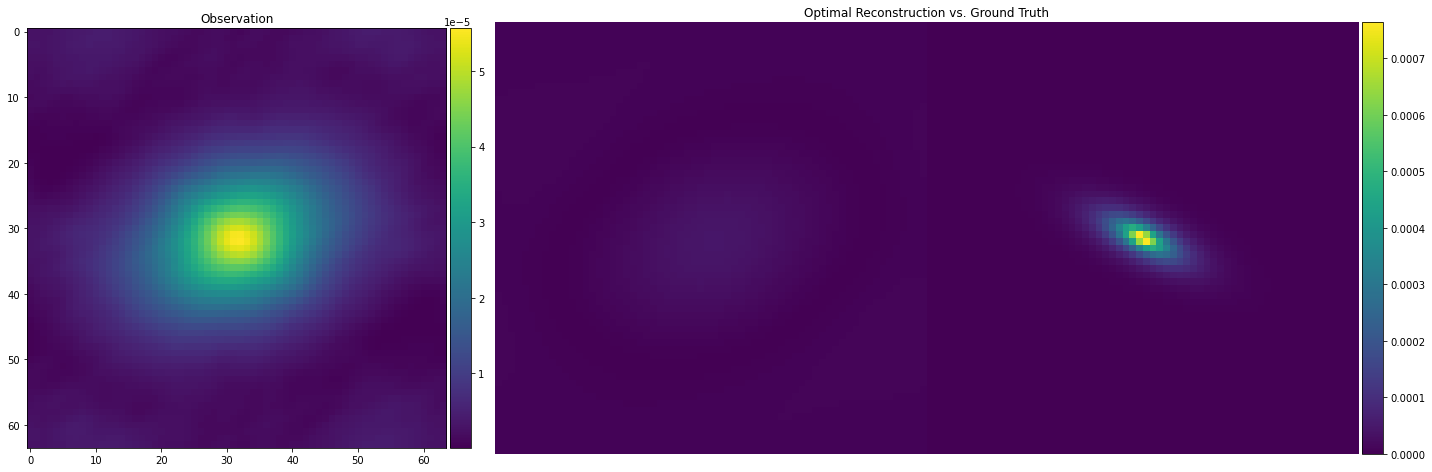

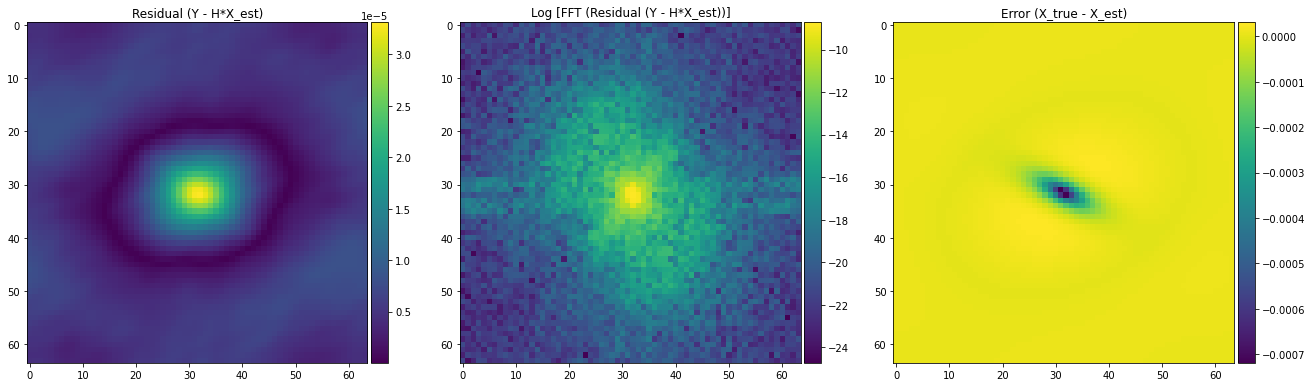

In [172]:
# Comparison

temp = tf.concat([x_opt, tf.math.real(gal_tf)], 1)

fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) 

ax1 = plt.subplot(gs[0])
plt.title('Observation')
ax1 = plt.gca()
im1 = ax1.imshow(tf.keras.backend.get_value(tf.math.abs(final_gal_tf)))
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax1)

ax2 = plt.subplot(gs[1])
plt.title('Optimal Reconstruction vs. Ground Truth')
ax2 = plt.gca()
im2 = ax2.imshow(tf.keras.backend.get_value(temp))
ax2.axis('off')
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="2.5%", pad=0.05)
plt.colorbar(im2, cax=cax2)

plt.tight_layout()


fig2 = plt.subplots(1,3, figsize=(22,22))
plt.subplot(131)
plt.title('Residual (Y - H*X_est)')
ax1 = plt.gca()
im1 = ax1.imshow(tf.keras.backend.get_value(tf.math.abs(final_gal_tf - fftconvolve(psf_tf, tf.cast(x_opt, dtype='complex128')))))
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax1)

plt.subplot(132)
plt.title('Log [FFT (Residual (Y - H*X_est))]')
ax2 = plt.gca()
im2 = ax2.imshow(tf.keras.backend.get_value(tf.math.log(tf.math.abs(fft(final_gal_tf - fftconvolve(psf_tf, tf.cast(x_opt, dtype='complex128')))))))
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax2)

plt.subplot(133)
plt.title('Error (X_true - X_est)')
ax3 = plt.gca()
im3 = ax3.imshow(tf.keras.backend.get_value(x_opt - tf.math.real(gal_tf)))
divider = make_axes_locatable(ax3)
cax3 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im3, cax=cax3)

plt.show(fig2)

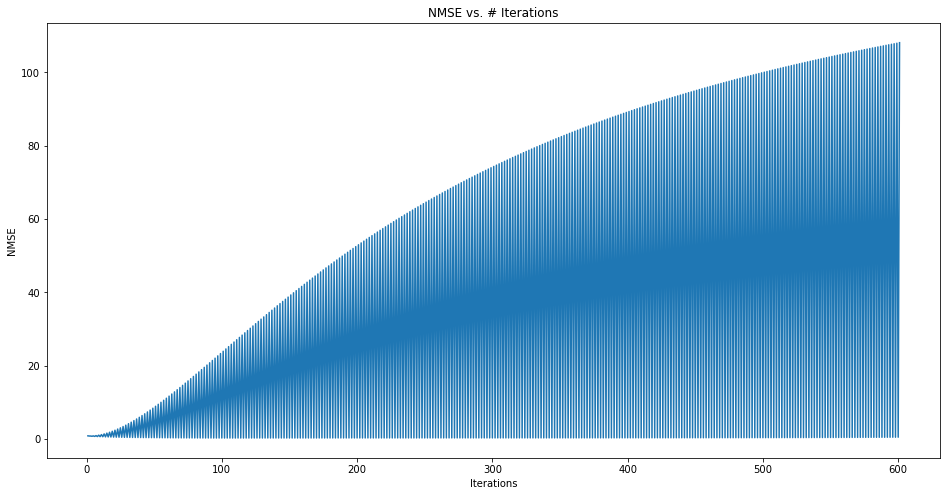


Minimum NMSE = 0.2522969450482823 (at 109 iterations)


In [173]:
min_nmse = np.min(nmse_arr)
min_iter = np.where(nmse_arr == min_nmse)[0][0]

plt.figure(figsize=(16,8))
plt.plot(np.arange(1,n_iter+1), nmse_arr)
plt.title('NMSE vs. # Iterations')
plt.xlabel('Iterations')
plt.ylabel('NMSE')
plt.show()
print('\nMinimum NMSE = {} (at {} iterations)'.format(min_nmse, min_iter))